In [27]:
from stockfish import Stockfish
stockfish = Stockfish("stockfish/stockfish-windows-x86-64-avx2.exe")

In [28]:
import chess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [29]:
data = pd.read_csv("data/positions.csv", low_memory=False)

In [30]:
sample = data

In [31]:
sample = sample.dropna(subset=["score"])

In [32]:
import chess

PIECE_VALUES = {
    chess.PAWN: 1,
    chess.KNIGHT: 3,
    chess.BISHOP: 3,
    chess.ROOK: 5,
    chess.QUEEN: 9
}

CENTER_SQUARES = [chess.D4, chess.E4, chess.D5, chess.E5]

def extract_features(board: chess.Board) -> list:
    features = []

    material_white = 0
    material_black = 0
    piece_counts = { (color, ptype): 0 for color in [chess.WHITE, chess.BLACK] 
                                        for ptype in PIECE_VALUES.keys() }
    center_control_white = 0
    center_control_black = 0
    white_in_black_half = 0
    black_in_white_half = 0
    pawn_files = {chess.WHITE: set(), chess.BLACK: set()}
    all_pawns = {chess.WHITE: [], chess.BLACK: []}
    open_files = set(range(8))
    halfopen_files = {chess.WHITE: set(), chess.BLACK: set()}
    outpost_knights = {chess.WHITE: 0, chess.BLACK: 0}
    developed_minors = {chess.WHITE: 0, chess.BLACK: 0}
    defended_pieces = {chess.WHITE: 0, chess.BLACK: 0}
    
    attackers_cache = {square: board.attackers(chess.WHITE, square) | board.attackers(chess.BLACK, square) for square in chess.SQUARES}

    for square in chess.SQUARES:
        piece = board.piece_at(square)
        if not piece:
            continue
        color = piece.color
        ptype = piece.piece_type
        rank = chess.square_rank(square)
        file = chess.square_file(square)

        # Material
        value = PIECE_VALUES.get(ptype, 0)
        if color == chess.WHITE:
            material_white += value
        else:
            material_black += value

        # Figurenzahl
        if ptype in PIECE_VALUES:
            piece_counts[(color, ptype)] += 1

        # Zentrum
        if square in CENTER_SQUARES:
            if color == chess.WHITE:
                center_control_white += 1
            else:
                center_control_black += 1

        # Gegnerische Hälfte
        if color == chess.WHITE and rank >= 4:
            white_in_black_half += 1
        elif color == chess.BLACK and rank <= 3:
            black_in_white_half += 1

        # Bauernanalyse
        if ptype == chess.PAWN:
            pawn_files[color].add(file)
            all_pawns[color].append(square)
            open_files.discard(file)
            halfopen_files[color].add(file)

        # Vorposten-Springer (grob: in Gegnerhälfte, nicht leicht durch Bauer vertreibbar)
        if ptype == chess.KNIGHT and ((color == chess.WHITE and rank >= 4) or (color == chess.BLACK and rank <= 3)):
            opp_color = not color
            # Kein gegnerischer Bauer kann dieses Feld angreifen (rudimentär)
            attackers = board.attackers(opp_color, square)
            if not any(board.piece_at(a).piece_type == chess.PAWN for a in attackers if board.piece_at(a)):
                outpost_knights[color] += 1

        # Entwicklung (Leichtfiguren nicht auf Grundreihe)
        if ptype in [chess.BISHOP, chess.KNIGHT] and ((color == chess.WHITE and rank > 0) or (color == chess.BLACK and rank < 7)):
            developed_minors[color] += 1

        # Verteidigte Figuren
        if len(board.attackers(color, square)) > 0:
            defended_pieces[color] += 1

    # Material
    features.append(material_white)
    features.append(material_black)
    features.append(material_white - material_black)

    # Figurenzählung
    for ptype in PIECE_VALUES:
        features.append(piece_counts[(chess.WHITE, ptype)])
        features.append(piece_counts[(chess.BLACK, ptype)])

    # Rochaden
    features.append(int(board.has_kingside_castling_rights(chess.WHITE)))
    features.append(int(board.has_queenside_castling_rights(chess.WHITE)))
    features.append(int(board.has_kingside_castling_rights(chess.BLACK)))
    features.append(int(board.has_queenside_castling_rights(chess.BLACK)))

    # Königsposition
    features.append(board.king(chess.WHITE))
    features.append(board.king(chess.BLACK))

    # Spieler am Zug
    features.append(int(board.turn))

    # Zentrum
    features.append(center_control_white)
    features.append(center_control_black)

    # Figuren in gegnerischer Hälfte
    features.append(white_in_black_half)
    features.append(black_in_white_half)

    # Mobilität
    features.append(len(list(board.legal_moves)))
    features.append(board.fullmove_number)

    # Neue Features (Reihenfolge beibehalten für separate Liste!)
    # 1. Doppelte Bauern
    features.append(sum(
        len([sq for sq in all_pawns[color] if chess.square_file(sq) == file]) > 1
        for color in [chess.WHITE, chess.BLACK]
        for file in pawn_files[color]
    ))

    # 2. Isolierte Bauern
    features.append(sum(
        all(
            file + offset not in pawn_files[color]
            for offset in [-1, 1]
        )
        for color in [chess.WHITE, chess.BLACK]
        for file in pawn_files[color]
    ))

    # 3. Halboffene Linien für Türme (eigene Bauern fehlen, Gegner evtl. nicht)
    for color in [chess.WHITE, chess.BLACK]:
        features.append(len(halfopen_files[color]))

    # 4. Offene Linien
    features.append(len(open_files))

    # 5. Springer auf Vorposten
    features.append(outpost_knights[chess.WHITE])
    features.append(outpost_knights[chess.BLACK])

    # 6. Entwicklung
    features.append(developed_minors[chess.WHITE])
    features.append(developed_minors[chess.BLACK])

    # 7. Verteidigte Figuren
    features.append(defended_pieces[chess.WHITE])
    features.append(defended_pieces[chess.BLACK])

    return features


In [33]:
feature_columns = [
    # Material
    "material_white",
    "material_black",
    "material_balance",

    # Anzahl Figuren pro Typ & Farbe (in fixer Reihenfolge) 
    "num_pawns_white",
    "num_pawns_black",
    "num_knights_white",
    "num_knights_black",
    "num_bishops_white",
    "num_bishops_black",
    "num_rooks_white",
    "num_rooks_black",
    "num_queens_white",
    "num_queens_black",

    # Rochaderechte
    "can_castle_k_white",
    "can_castle_q_white",
    "can_castle_k_black",
    "can_castle_q_black",

    # Königspositionen (0–63)
    "king_square_white",
    "king_square_black",

    # Spieler am Zug
    "is_white_to_move",

    # Zentrumskontrolle
    "center_control_white",
    "center_control_black",

    # Figuren auf gegnerischer Hälfte
    "white_pieces_in_black_half",
    "black_pieces_in_white_half",

    # Züge
    "legal_moves_total",
    "num_total_moves",
    
        # Bauernstruktur
    "num_doubled_pawns_total",
    "num_isolated_pawns_total",

    # Linienkontrolle
    "num_halfopen_files_white",
    "num_halfopen_files_black",
    "num_open_files_total",

    # Springer auf Vorposten
    "num_knight_outposts_white",
    "num_knight_outposts_black",

    # Entwicklung
    "num_developed_minors_white",
    "num_developed_minors_black",

    # Koordination
    "num_defended_pieces_white",
    "num_defended_pieces_black"
]


In [34]:
features_df = []
scores = sample["score"].values
i = 0
for fen in sample["fen"]:
    if i % 20 == 0:
        print(i)
    i += 1
    board = chess.Board(fen)
    features = extract_features(board)
    features_df.append(features)
scores = np.array(scores)
features_df = pd.DataFrame(features_df, columns=feature_columns)

0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500
520
540
560
580
600
620
640
660
680
700
720
740
760
780
800
820
840
860
880
900
920
940
960
980
1000
1020
1040
1060
1080
1100
1120
1140
1160
1180
1200
1220
1240
1260
1280
1300
1320
1340
1360
1380
1400
1420
1440
1460
1480
1500
1520
1540
1560
1580
1600
1620
1640
1660
1680
1700
1720
1740
1760
1780
1800
1820
1840
1860
1880
1900
1920
1940
1960
1980
2000
2020
2040
2060
2080
2100
2120
2140
2160
2180
2200
2220
2240
2260
2280
2300
2320
2340
2360
2380
2400
2420
2440
2460
2480
2500
2520
2540
2560
2580
2600
2620
2640
2660
2680
2700
2720
2740
2760
2780
2800
2820
2840
2860
2880
2900
2920
2940
2960
2980
3000
3020
3040
3060
3080
3100
3120
3140
3160
3180
3200
3220
3240
3260
3280
3300
3320
3340
3360
3380
3400
3420
3440
3460
3480
3500
3520
3540
3560
3580
3600
3620
3640
3660
3680
3700
3720
3740
3760
3780
3800
3820
3840
3860
3880
3900
3920
3940
3960
3980
4000
4020
4040
4060
4080
4100
4120
4140
4160
4180
4200
4

KeyboardInterrupt: 

In [35]:
features_df = pd.DataFrame(np.load("features_np. npy.npy"), columns=feature_columns)
scores = sample["score"].values

In [36]:
from sklearn.model_selection import train_test_split

features_train, features_test, labels_train, labels_test = train_test_split(features_df, scores, test_size=0.2, random_state=42)

In [38]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=150, random_state=42, n_jobs=-1, max_depth=50)
model.fit(features_train, labels_train)

RandomForestRegressor(max_depth=50, n_estimators=150, n_jobs=-1,
                      random_state=42)

In [39]:
y_pred = model.predict(features_test)


In [40]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print("MSE:", mean_squared_error(labels_test, y_pred))
print("MAE:", mean_absolute_error(labels_test, y_pred))
print("R²:", r2_score(labels_test, y_pred))


MSE: 206650.7393326072
MAE: 167.5643419225938
R²: 0.515473313092328


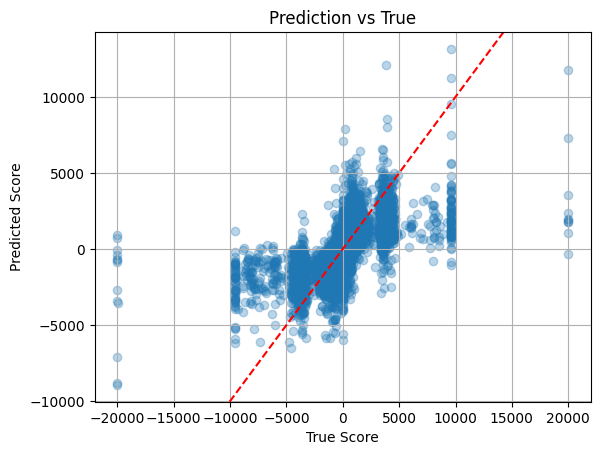

In [41]:
import matplotlib.pyplot as plt

plt.scatter(labels_test, y_pred, alpha=0.3)
plt.xlabel("True Score")
plt.ylabel("Predicted Score")
plt.title("Prediction vs True")
plt.grid(True)
plt.axline((0,0), slope=1, color='r', linestyle='--')
plt.show()


In [50]:
def negamax(board, alpha, beta, model, depth=4):
    if depth == 0 or board.is_game_over():
        features = extract_features(board)
        eval = model.predict([features])[0]
        # Negiere, falls schwarzer Spieler am Zug
        score = eval if board.turn == chess.WHITE else -eval
        return score, None  # <<< WICHTIG: Rückgabe immer als Tupel!

    max_eval = -float('inf')
    best_move = None

    for move in board.legal_moves:
        board.push(move)
        eval, _ = negamax(board, -beta, -alpha, model, depth - 1)
        eval = -eval
        board.pop()

        if eval > max_eval:
            max_eval = eval
            best_move = move

        alpha = max(alpha, eval)
        if alpha >= beta:
            break  # Beta-Cutoff

    return max_eval, best_move  # <<< Rückgabe als Tupel


In [51]:
import chess.svg
board = chess.Board()

OUTPUT_FILE = "Board"
# Spiel-Loop
while not board.is_game_over():
    print(board)
    print("Your move (e.g., e2e4):")

    user_move = None
    while True:
        move_input = input(">> ").strip()
        try:
            user_move = chess.Move.from_uci(move_input)
            if user_move in board.legal_moves:
                board.push(user_move)
                break
            else:
                print("Illegal move. Try again.")
        except:
            print("Invalid format. Try again (e.g., e2e4).")

    # SVG nach Nutzerzug speichern
    with open(OUTPUT_FILE, "w") as f:
        f.write(chess.svg.board(board))

    if board.is_game_over():
        break

    print("Computer is thinking...")
    _, best_move = negamax(board, -float("inf"), float("inf"), model, depth=2)
    board.push(best_move)
    print(f"Computer plays: {best_move}")

    # SVG nach Computzug speichern
    with open(OUTPUT_FILE, "w") as f:
        f.write(chess.svg.board(board))

# Spielende anzeigen
print(board)
print("Game over:", board.result())

r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
P P P P P P P P
R N B Q K B N R
Your move (e.g., e2e4):
Computer is thinking...


C:\Users\felix\anaconda3\envs\chess_AI\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\felix\anaconda3\envs\chess_AI\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\felix\anaconda3\envs\chess_AI\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\felix\anaconda3\envs\chess_AI\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\felix\anaconda3\envs\chess_AI\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but

Computer plays: b7b6
r n b q k b n r
p . p p p p p p
. p . . . . . .
. . . . . . . .
. . . . P . . .
. . . . . . . .
P P P P . P P P
R N B Q K B N R
Your move (e.g., e2e4):
Invalid format. Try again (e.g., e2e4).
Invalid format. Try again (e.g., e2e4).
Computer is thinking...


C:\Users\felix\anaconda3\envs\chess_AI\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\felix\anaconda3\envs\chess_AI\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\felix\anaconda3\envs\chess_AI\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\felix\anaconda3\envs\chess_AI\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\felix\anaconda3\envs\chess_AI\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but

Computer plays: c7c5
r n b q k b n r
p . . p p p p p
. p . . . . . .
. . p . . . . .
. . . . P . . .
P . . . . . . .
. P P P . P P P
R N B Q K B N R
Your move (e.g., e2e4):
Invalid format. Try again (e.g., e2e4).
Invalid format. Try again (e.g., e2e4).
Illegal move. Try again.
Computer is thinking...


C:\Users\felix\anaconda3\envs\chess_AI\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\felix\anaconda3\envs\chess_AI\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\felix\anaconda3\envs\chess_AI\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\felix\anaconda3\envs\chess_AI\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\felix\anaconda3\envs\chess_AI\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but

KeyboardInterrupt: 